<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Performace_Enhanced_Auto_Regreesion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker = 'NIFTYBEES.NS'
prev_day = 1
scale_factor = 1.0

history_length = 200
forecast_length = 50

arima_p = 20

In [4]:
def get_previous_trading_day(ref_date):
    """
    Given a reference date, return the previous trading day.
    This simple logic assumes that weekends are non-trading days.
    For more robust handling (e.g. holidays), consider using a market calendar.
    """
    weekday = ref_date.weekday()
    # Monday: go back to Friday (3 days)
    if weekday == 0:
        return ref_date - timedelta(days=3)
    # Sunday: go back to Friday (2 days)
    elif weekday == 6:
        return ref_date - timedelta(days=2)
    # Saturday: go back to Friday (1 day)
    elif weekday == 5:
        return ref_date - timedelta(days=1)
    else:
        # For Tuesday to Friday, subtract one day.
        return ref_date - timedelta(days=1)


In [5]:
def download_data(entity):
    # Determine today's date and then compute the previous trading day.
    today = datetime.today().date() - timedelta(days = prev_day)
    prev_trading_day = get_previous_trading_day(today)

    # Format start and end dates.
    # Note: When using yfinance, the 'end' date is non-inclusive.
    start_date = prev_trading_day.strftime("%Y-%m-%d")
    end_date = (prev_trading_day + timedelta(days=1)).strftime("%Y-%m-%d")

    print(f"Downloading {ticker} intraday data for {start_date}")

    # Download intraday data with a 1-minute interval.
    data = yf.download(ticker, start=start_date, end=end_date, interval="1m")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    entity['data'] = data_

In [6]:
def calculate_return(entity):
    data = entity['data']

    data.eval('log_S = log(S)', inplace = True)
    data['r'] = scale_factor * data['log_S'].diff()

In [7]:
def feature_engg(entity):
    data = entity['data']

    features_df = data[['r']]

    for idx in range(arima_p):
        features_df[f'r_{idx + 1}'] = features_df['r'].shift(idx + 1)

    features_df.dropna(inplace = True)

    entity['features'] = features_df

In [8]:
def split_data(entity):
    features_df = entity['features']
    train_data = features_df.iloc[: history_length]
    test_data = features_df.iloc[history_length : history_length + forecast_length]

    entity['train'] = train_data
    entity['test'] = test_data

In [9]:
def fit_ar_model(entity):
    formula = 'r ~ ' + " + ".join([f'r_{idx + 1}' for idx in range(arima_p)])

    fit_model = smf.ols(formula, data = entity['train']).fit()

    entity['ar_model'] = fit_model

In [10]:
def create_vol_data(entity):
    entity['vol_train'] = pd.DataFrame({'e' : entity['ar_model'].resid})
    entity['vol_train'].eval('log_e_sq = log(e ** 2)', inplace = True)

    for idx in range(arima_p):
        entity['vol_train'][f'log_e_sq_{idx + 1}'] = entity['vol_train']['log_e_sq'].shift(idx + 1)

    entity['vol_train'].dropna(inplace = True)

In [11]:
def fit_vol_model(entity):
    formula = 'log_e_sq ~ ' + " + ".join([f'log_e_sq_{idx + 1}' for idx in range(arima_p)])

    entity['vol_model'] = smf.ols(formula, data = entity['vol_train']).fit()

In [12]:
def forecast_mean(entity):
    prev_data = entity['train'].iloc[-arima_p:]['r'].values.tolist()
    prev_r = entity['train']['r'].iloc[-1]

    intercept = entity['ar_model'].params.values[0]
    slopes = entity['ar_model'].params.values[1:]

    dataset = []

    for idx in range(forecast_length):
        last_value = prev_data[-arima_p:]
        input_features = np.array(last_value[::-1])
        preds = intercept + np.dot(slopes, input_features)
        prev_data += [preds]

        dataset += [[preds] + input_features.tolist()]

    entity['ar_diagnosis'] = pd.DataFrame(
        data = dataset,
        columns = ['r'] + [f'r_{idx + 1}' for idx in range(arima_p)],
        index = entity['test'].index
    )

    forecast_data = prev_data[arima_p:]

    entity['mean_forecast'] = pd.DataFrame({
        'r' : forecast_data
    }, index = entity['test'].index)

In [13]:
entity = {}
download_data(entity)
calculate_return(entity)
feature_engg(entity)
split_data(entity)
fit_ar_model(entity)
create_vol_data(entity)
fit_vol_model(entity)
forecast_mean(entity)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [14]:
print(entity['ar_model'].summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.264
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.209
Time:                        10:45:00   Log-Likelihood:                 1440.8
No. Observations:                 200   AIC:                            -2840.
Df Residuals:                     179   BIC:                            -2770.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.958e-06   1.35e-05     -0.663      0.5

In [15]:
print(entity['vol_model'].summary())

                            OLS Regression Results                            
Dep. Variable:               log_e_sq   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.7204
Date:                Thu, 27 Feb 2025   Prob (F-statistic):              0.801
Time:                        10:45:00   Log-Likelihood:                -399.38
No. Observations:                 180   AIC:                             840.8
Df Residuals:                     159   BIC:                             907.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -8.6930      4.970     -1.749      

<Axes: xlabel='Datetime', ylabel='r'>

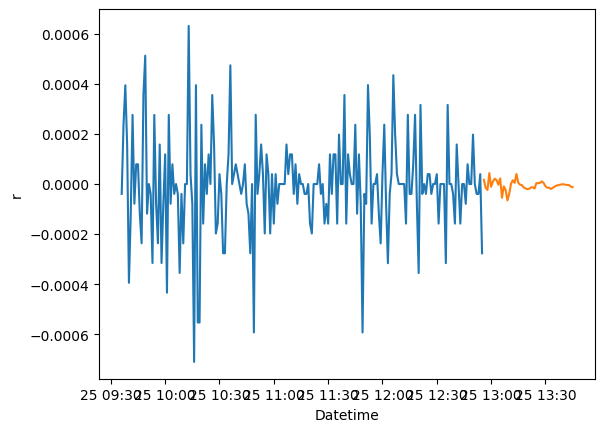

In [16]:
sns.lineplot(x = 'Datetime', y = 'r', data = entity['train'].reset_index())
sns.lineplot(x = 'Datetime', y = 'r', data = entity['mean_forecast'].reset_index())

<Axes: xlabel='Datetime', ylabel='S'>

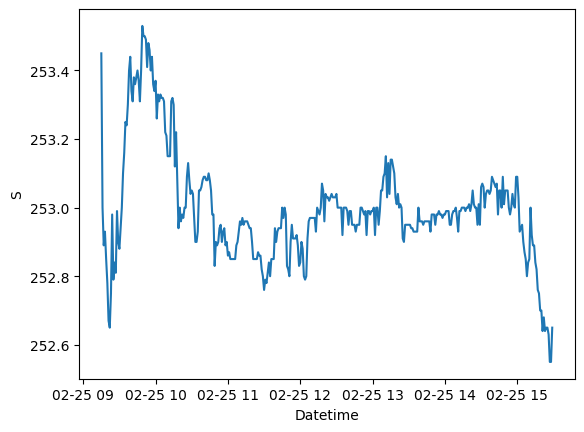

In [17]:
sns.lineplot(x = 'Datetime', y = 'S', data = entity['data'].reset_index())

In [18]:
len(entity['data'])

375